In [180]:
%config InlineBackend.figure_formats = ['svg']

In [375]:
import random
import numpy as np
import pandas as pd
from joblib import dump, load
np.random.seed(42)
random.seed(42)

In [469]:
data_dir = './data/'
with np.load('data/Xy.npz') as f:
    X = f['X']
    y = f['y']
    y34 = f['y34']

In [3]:
# Perform temporal split of data into train/test sets
pop = pd.read_csv(data_dir + 'population/d10_with_vitals.csv').set_index('BMT_ID')

split_date = 201701001
split_idx = -85

assert (pop[:split_idx].index < split_date).all()
assert (pop[split_idx:].index >= split_date).all()

In [4]:
from sklearn import preprocessing, model_selection, metrics, utils
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.base import clone

In [5]:
# Specify hyperparameters and cv parameters
base_estimator = LogisticRegression(penalty='l2', class_weight='balanced', solver='liblinear')
param_grid = {
    'C': [10. ** n for n in range(-6, 7)],
    'penalty': ['l2'],
}

## Alternative label definition
{0,1,2} -> negative, {3,4} -> positive

In [472]:
y.mean(), y34.mean()

(0.31790123456790126, 0.13580246913580246)

In [376]:
Xtr, Xte = X[:split_idx], X[split_idx:]
ytr, yte = y34[:split_idx], y34[split_idx:]

cv_splits, cv_repeat = 5, 20
cv = model_selection.RepeatedStratifiedKFold(cv_splits, cv_repeat, random_state=0)
clf = model_selection.GridSearchCV(
    clone(base_estimator), param_grid, 
    cv=cv, scoring='roc_auc', n_jobs=5,
)
clf.fit(Xtr, ytr)
test_score = metrics.roc_auc_score(yte, clf.decision_function(Xte))

/data4/tangsp/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [377]:
y_true = yte
y_score = clf.decision_function(Xte)

def boostrap_func(i, y_true, y_score):
    yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
    return metrics.roc_curve(yte_true_b, yte_pred_b), metrics.roc_auc_score(yte_true_b, yte_pred_b)

roc_curves, auc_scores = zip(*Parallel(n_jobs=4)(delayed(boostrap_func)(i, y_true, y_score) for i in tqdm(range(1000), leave=False)))
print('Test AUC: {:.3f} ({:.3f}, {:.3f})'.format(np.median(auc_scores), np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))

Test AUC: 0.596 (0.423, 0.761)


## Random Forest model

In [378]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import scipy

In [379]:
Xtr, Xte = X[:split_idx], X[split_idx:]
ytr, yte = y[:split_idx], y[split_idx:]

cv_splits, cv_repeat = 5, 20
cv = model_selection.RepeatedStratifiedKFold(cv_splits, cv_repeat, random_state=0)
clf = RandomizedSearchCV(
        RandomForestClassifier(), 
        {
            "criterion": ["gini", "entropy"],
            "max_depth": [4, 8, 16, 32, None],
            "max_features": scipy.stats.randint(1, 100),
            "min_samples_split": scipy.stats.randint(2, 11),
            "min_samples_leaf": scipy.stats.randint(1, 11),
            "n_estimators": scipy.stats.randint(50,500),
            "bootstrap": [True],
        },
        n_iter=10,
        cv=cv,
        scoring='roc_auc',
        n_jobs=5,
    )

clf.fit(Xtr, ytr)

RandomizedSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7f9b8ffacc50>,
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_sample...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9b8ffad

In [380]:
test_score = metrics.roc_auc_score(yte, clf.predict_proba(Xte)[:,1])

In [381]:
y_true = yte
y_score = clf.predict_proba(Xte)[:,1]

def boostrap_func(i, y_true, y_score):
    yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
    return metrics.roc_curve(yte_true_b, yte_pred_b), metrics.roc_auc_score(yte_true_b, yte_pred_b)

_, auc_scores_rf = zip(*Parallel(n_jobs=4)(delayed(boostrap_func)(i, y_true, y_score) for i in tqdm(range(1000), leave=False)))
print('Test AUC: {:.3f} ({:.3f}, {:.3f})'.format(np.median(auc_scores_rf), np.percentile(auc_scores_rf, 2.5), np.percentile(auc_scores_rf, 97.5)))

Test AUC: 0.651 (0.525, 0.768)


In [382]:
clf_main = load('data/model_combined.joblib')
y_score = clf_main.predict_proba(Xte)[:,1]
_, auc_scores_main = zip(*Parallel(n_jobs=4)(delayed(boostrap_func)(i, y_true, y_score) for i in tqdm(range(1000), leave=False)))
print('Test AUC: {:.3f} ({:.3f}, {:.3f})'.format(
    np.median(auc_scores_main), np.percentile(auc_scores_main, 2.5), np.percentile(auc_scores_main, 97.5)))

Test AUC: 0.658 (0.536, 0.784)


In [383]:
# H0: proposed == baseline
# H1: proposed != baseline
# resampling test, two-sided p-value
2 * min(
    (np.array(auc_scores_main) < np.array(auc_scores_rf)).mean(),
    (np.array(auc_scores_main) > np.array(auc_scores_rf)).mean()
)

0.782

## Kaplan Meier plot

In [479]:
import matplotlib.pyplot as plt
from sklearn import utils

In [482]:
Xtr, Xte = X[:split_idx], X[split_idx:]
ytr, yte = y[:split_idx], y[split_idx:]

In [483]:
pop = pd.read_csv(data_dir + 'population/d10_with_vitals.csv').set_index('BMT_ID')
labels = pd.read_csv(data_dir + 'prep/label.csv').set_index('BMT_ID')
IDs = pop.index[split_idx:]
onset = labels.loc[IDs, 'GVHD_onset_day'].replace(np.nan, np.inf)

In [484]:
clf = load('data/model_combined.joblib')
threshold = np.percentile(clf.predict_proba(Xtr)[:,1], [0, 70, 100])
y_prob = clf.predict_proba(Xte)[:,1]
y_group = pd.cut(y_prob, threshold)
print(y_group.categories)
y_group = y_group.codes

IntervalIndex([(0.234, 0.539], (0.539, 0.74]],
              closed='right',
              dtype='interval[float64]')


In [485]:
# Standard errors calculated via the Greenwood's formula
# http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Survival/BS704_Survival4.html
def calculate_survival_curve_se(onset_m, times):
    surv_probs = [(onset_m > 0).mean()]
    stderrs = [0]
    quotients = []
    for day in sorted(times):
        if np.isfinite(day):
            Nt, Dt = (onset_m >= day).sum(), (onset_m == day).sum()
            St = (onset_m > day).mean()
            quotients.append(Dt / (Nt * (Nt - Dt)))
            surv_probs.append(St)
            stderrs.append(St * np.sqrt(np.sum(quotients)))
    return np.array(surv_probs), np.array(stderrs)

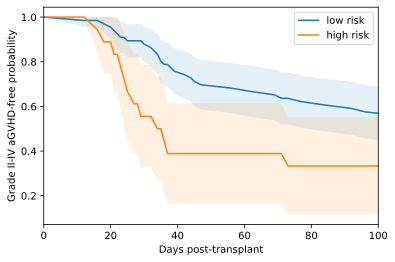

In [486]:
times = onset.unique()
times = times[times <= 105]
times = sorted(times)

for group in [0,1]:
    m = (y_group == group)
    o_m = onset[m]
    surv_probs, stderrs = calculate_survival_curve_se(o_m, times)
    CI = [
        np.clip(surv_probs - 1.96 * stderrs, 0, 1), 
        np.clip(surv_probs + 1.96 * stderrs, 0, 1),
    ]
    plt.plot([0] + times, surv_probs)
    plt.fill_between([0] + times, CI[0], CI[1], alpha=0.12)

plt.xlim(0,100)
plt.legend(labels=['low risk', 'high risk'])
plt.xlabel('Days post-transplant')
plt.ylabel('Grade II-IV aGVHD-free probability')
plt.savefig('fig/kaplan_meier.svg')
plt.show()

## Clustering results

`'Temp-slope', 'Temp-abs(A1)', 'Temp-angle(A1)', 'SBP-abs(A1)'`

In [119]:
from sklearn import preprocessing
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA

In [86]:
extracted_features = pd.read_csv('data/ts_features.csv', index_col='id')

In [100]:
extracted_features.head()

,"DiaBP_dt=1_max__fft_coefficient__coeff_1__attr_""abs""","DiaBP_dt=1_max__fft_coefficient__coeff_1__attr_""angle""","DiaBP_dt=1_max__linear_trend__attr_""slope""",DiaBP_dt=1_max__mean,DiaBP_dt=1_max__sample_entropy,"DiaBP_dt=1_mean__fft_coefficient__coeff_1__attr_""abs""","DiaBP_dt=1_mean__fft_coefficient__coeff_1__attr_""angle""","DiaBP_dt=1_mean__linear_trend__attr_""slope""",DiaBP_dt=1_mean__mean,DiaBP_dt=1_mean__sample_entropy,...,"Temp_dt=1_min__fft_coefficient__coeff_1__attr_""abs""","Temp_dt=1_min__fft_coefficient__coeff_1__attr_""angle""","Temp_dt=1_min__linear_trend__attr_""slope""",Temp_dt=1_min__mean,Temp_dt=1_min__sample_entropy,"Temp_dt=1_std__fft_coefficient__coeff_1__attr_""abs""","Temp_dt=1_std__fft_coefficient__coeff_1__attr_""angle""","Temp_dt=1_std__linear_trend__attr_""slope""",Temp_dt=1_std__mean,Temp_dt=1_std__sample_entropy
id,,,,,,,,,,,,,,,,,,,,,
201406001,13.711126,-39.840250,-1.151515,80.8,1.504077,12.511950,-60.302991,-0.771727,70.326825,2.420368,...,0.567878,73.555730,0.021481,36.518889,1.860752,0.263259,69.530757,0.018092,0.220617,2.420368
201406002,3.452240,42.925589,-0.066667,77.5,2.420368,17.946614,-14.951144,-0.530707,69.379524,2.014903,...,0.164019,-59.464582,0.009091,36.316667,2.420368,0.265981,100.908363,0.004882,0.268865,2.708050
201406003,14.437545,161.710499,-0.151515,86.9,2.708050,18.338949,-169.211341,0.150459,76.578379,1.860752,...,0.501112,-73.426276,-0.042088,36.172222,2.420368,0.431178,-149.344978,-0.000899,0.284152,2.197225
201406004,39.672864,-56.532935,-0.939394,78.7,2.014903,21.591328,-62.275730,-0.655020,67.781822,1.504077,...,1.444653,145.906924,0.045118,35.911111,2.197225,0.420941,-3.505990,-0.006831,0.225669,1.727221
201406005,46.236218,-83.519009,-2.454545,77.7,2.014903,45.041080,-100.861026,-1.821655,69.535720,2.708050,...,2.181057,78.501122,0.113805,36.288889,2.420368,0.512131,118.454862,0.030110,0.271239,2.014903


In [89]:
cols = [
    c for c in extracted_features.columns
    if c.startswith('Temp') or c.startswith('SysBP')
]
cols = [
    c for c in cols
    if \
    ('Temp' in c and 'slope' in c) or \
    ('Temp' in c and 'fft_coefficient__coeff_1__attr_"abs"' in c) or \
    ('Temp' in c and 'fft_coefficient__coeff_1__attr_"angle"' in c) or \
    ('SysBP' in c and 'fft_coefficient__coeff_1__attr_"abs"' in c)
]

In [96]:
XX = extracted_features[cols].values
scaler = preprocessing.StandardScaler()
XX = scaler.fit_transform(XX)

In [97]:
XX.shape

(324, 16)

In [104]:
pca = PCA(2, random_state=0).fit(XX)

In [176]:
clusterings = [np.nan, np.nan]
scores = [np.nan, np.nan]
for k in range(2,11):
    cluster = KMeans(k, random_state=0, n_init=20, n_jobs=-1).fit(XX)
    clusterings.append(cluster)
    scores.append(cluster.inertia_)
#     purities, sizes = [], []
#     for c in range(k):
#         m = (cluster.labels_ == c)
#         yc = y[m].mean()
#         purities.append(max(yc, 1-yc))
#         sizes.append(sum(m) / len(y))
#     purity = np.array(purities) @ np.array(sizes)
#     scores.append(purity)

In [ ]:
plt.plot(scores)

In [220]:
k = 3
cluster = clusterings[k]
pred = cluster.fit_predict(XX)

In [221]:
purities, majority = [], []
for c in range(k):
    m = (cluster.labels_ == c)
    yc = y[m].mean()
    purities.append(max(yc, 1-yc))

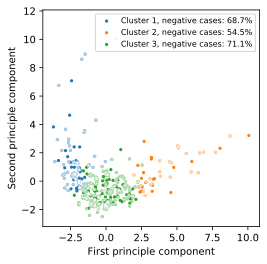

In [363]:
# plt.scatter(*pca.transform(XX).T, c=y, s=5, cmap='bwr')
X_pca = pca.transform(XX)
for i in range(k):
    plt.scatter(*X_pca[pred == i].T, c=[plt.get_cmap("tab10")(i)], s=5, 
                label='Cluster {}, negative cases: {:.1%}'.format(i+1, purities[i]))

# plt.scatter(*X_pca.T, c=[plt.get_cmap("tab10")(ci) for ci in pred], s=5)

# Mark negative cases with lighter color
plt.scatter(*X_pca.T, c=[{0: '#ffffff88', 1: '#00000000'}[yi] for yi in y], s=5)

plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.legend(fontsize=8)
plt.axis('square')
plt.savefig('fig/cluster.svg', bbox_inches='tight')
plt.show()

## Visualize time series

In [316]:
import pickle
ts_vitals_by_bmt = pickle.load(open(data_dir + 'features/ts_vitals_by_bmt_2014_2017_MiChart.p', 'rb'))
ts_vitals_by_bmt = {ID: ts_vitals_by_bmt[ID] for ID in list(pop.index)}
split_idx = len(ts_vitals_by_bmt)-85

clf = load('data/model_combined.joblib')
y_prob = clf.predict_proba(Xte)[:,1]

In [310]:
imax, imin = y_prob.argmax(), y_prob.argmin()

In [325]:
ID_max = pop.index[split_idx+imax]
ts_imax = ts_vitals_by_bmt[ID_max]
ID_min = pop.index[split_idx+imin]
ts_imin = ts_vitals_by_bmt[ID_min]

In [327]:
ID_max, ID_min

(201708006, 201711007)

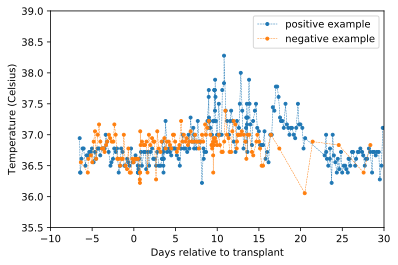

In [361]:
ts_plot = ts_imax[ts_imax['t'] >= -10][['t', 'Temp']].dropna()
plt.plot(ts_plot['t'], ts_plot['Temp'], '.--', lw=0.5, label='positive example')

ts_plot = ts_imin[ts_imin['t'] >= -10][['t', 'Temp']].dropna()
plt.plot(ts_plot['t'], ts_plot['Temp'], '.--', lw=0.5, label='negative example')

plt.xlim(-10, 30)
plt.ylim(35.5, 39)
plt.xlabel('Days relative to transplant')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.savefig('fig/timeseries_Temperature.svg')
plt.show()

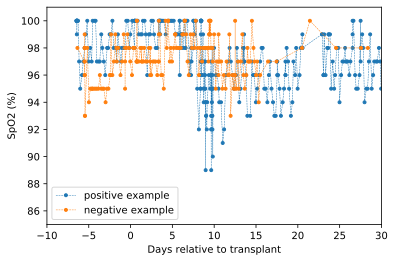

In [362]:
ts_plot = ts_imax[ts_imax['t'] >= -10][['t', 'SpO2']].dropna()
plt.plot(ts_plot['t'], ts_plot['SpO2'], '.--', lw=0.5, label='positive example')

ts_plot = ts_imin[ts_imin['t'] >= -10][['t', 'SpO2']].dropna()
plt.plot(ts_plot['t'], ts_plot['SpO2'], '.--', lw=0.5, label='negative example')

plt.xlim(-10, 30)
plt.ylim(85, 101)
plt.xlabel('Days relative to transplant')
plt.ylabel('SpO2 (%)')
plt.legend()
plt.savefig('fig/timeseries_SpO2.svg')
plt.show()

In [414]:
from scipy.interpolate import interp1d

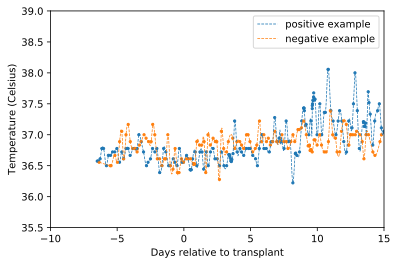

In [456]:
# Smoothed version
ts_plot = ts_imax[(ts_imax['t'] >= -10) & (ts_imax['t'] < 15)][['t', 'Temp']].dropna()
ts_plot = ts_plot.set_index('t')
ts_plot['Temp_MA'] = np.nan
wsize = 0.1
for t in ts_plot.index:
    ts_plot.loc[t, 'Temp_MA'] = np.mean(ts_plot.loc[
        (t-wsize < ts_plot.index) & (ts_plot.index < t+wsize), 'Temp'
    ])
ts_plot = ts_plot.reset_index()
x = ts_plot['t']
y = ts_plot['Temp_MA']
x_new = np.linspace(x.min(), x.max(), 1000)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
plt.plot(x_new, y_smooth, '--', lw=0.75, label='positive example')
# plt.plot(ts_plot['t'], ts_plot['Temp_MA'], '-', lw=1, label='positive example')
plt.scatter(ts_plot['t'], ts_plot['Temp_MA'], s=5)

ts_plot = ts_imin[(ts_imin['t'] >= -10) & (ts_imin['t'] < 15)][['t', 'Temp']].dropna()
ts_plot = ts_plot.set_index('t')
ts_plot['Temp_MA'] = np.nan
wsize = 0.1
for t in ts_plot.index:
    ts_plot.loc[t, 'Temp_MA'] = np.mean(ts_plot.loc[
        (t-wsize < ts_plot.index) & (ts_plot.index < t+wsize), 'Temp'
    ])
ts_plot = ts_plot.reset_index()
x = ts_plot['t']
y = ts_plot['Temp_MA']
x_new = np.linspace(x.min(), x.max(), 1000)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
plt.plot(x_new, y_smooth, '--', lw=0.75, label='negative example')
# plt.plot(ts_plot['t'], ts_plot['Temp_MA'], '-', lw=1, label='negative example')
plt.scatter(ts_plot['t'], ts_plot['Temp_MA'], s=5)

plt.xlim(-10, 15)
plt.ylim(35.5, 39)
plt.xlabel('Days relative to transplant')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.savefig('fig/timeseries_Temperature.svg')
plt.show()

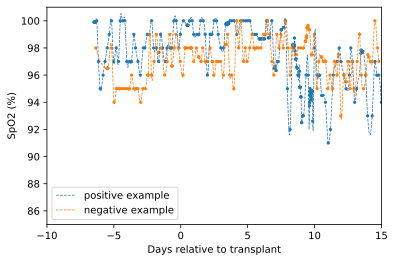

In [466]:
# Smoothed version
ts_plot = ts_imax[(ts_imax['t'] >= -10) & (ts_imax['t'] < 15)][['t', 'SpO2']].dropna()
ts_plot = ts_plot.set_index('t')
ts_plot['SpO2_MA'] = np.nan
wsize = 0.1
for t in ts_plot.index:
    ts_plot.loc[t, 'SpO2_MA'] = np.mean(ts_plot.loc[
        (t-wsize < ts_plot.index) & (ts_plot.index < t+wsize), 'SpO2'
    ])
ts_plot = ts_plot.reset_index()
ts_plot = ts_plot.sort_values(by=['t'])
ts_plot = ts_plot.drop_duplicates(subset=['t'])
x = ts_plot['t']
y = ts_plot['SpO2_MA']
x_new = np.linspace(x.min(), x.max(), 1000)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
plt.plot(x_new, y_smooth, '--', lw=0.75, label='positive example')
# plt.plot(ts_plot['t'], ts_plot['SpO2_MA'], '-', lw=1, label='positive example')
plt.scatter(ts_plot['t'], ts_plot['SpO2_MA'], s=5)

ts_plot = ts_imin[(ts_imin['t'] >= -10) & (ts_imin['t'] < 15)][['t', 'SpO2']].dropna()
ts_plot = ts_plot.set_index('t')
ts_plot['SpO2_MA'] = np.nan
wsize = 0.1
for t in ts_plot.index:
    ts_plot.loc[t, 'SpO2_MA'] = np.mean(ts_plot.loc[
        (t-wsize < ts_plot.index) & (ts_plot.index < t+wsize), 'SpO2'
    ])
ts_plot = ts_plot.reset_index()
ts_plot = ts_plot.sort_values(by=['t'])
ts_plot = ts_plot.drop_duplicates(subset=['t'])
x = ts_plot['t']
y = ts_plot['SpO2_MA']
x_new = np.linspace(x.min(), x.max(), 1000)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
plt.plot(x_new, y_smooth, '--', lw=0.75, label='negative example')
# plt.plot(ts_plot['t'], ts_plot['SpO2_MA'], '-', lw=1, label='negative example')
plt.scatter(ts_plot['t'], ts_plot['SpO2_MA'], s=5)

plt.xlim(-10, 15)
plt.ylim(85, 101)
plt.xlabel('Days relative to transplant')
plt.ylabel('SpO2 (%)')
plt.legend()
plt.savefig('fig/timeseries_SpO2.svg')
plt.show()